# Text-to-Image library (Stable Diffusion)

Stable Diffusion is a latent text-to-image diffusion model capable of generating photo-realistic images given any text prompt as input. The model was created by the researchers and engineers from CompVis, Stability AI, runway, and LAION.

For more information about how Stable Diffusion functions, please go through [🤗's Stable Diffusion with 🧨Diffusers blog](https://huggingface.co/blog/stable_diffusion).


- check if you can access GPU from docker JupyterLab container

In [1]:
!nvidia-smi

Tue Mar 14 16:22:35 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN RTX                On | 00000000:00:05.0 Off |                  N/A |
| 41%   29C    P8               13W / 280W|   5842MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 1. Import required packages

- [🤗 🧨Diffusers](https://huggingface.co/docs/diffusers/index) provides pretrained vision and audio diffusion models and a great toolset for inference and training

- `StableDiffusionPipeline` is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code.

In [2]:
import os
import torch
from diffusers import StableDiffusionPipeline

### 2. Setup StableDiffusion Pipeline

- There are different checkpoints / models available for text2img inferencing from HuggingFace. In this notebook, we would be using ``CompVis/stable-diffusion-v1-4``. The other variations of the model can be found [here](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/text2img).

In [3]:
model_id = "CompVis/stable-diffusion-v1-4"

- To generate User access tokens, please go through the link [here](https://huggingface.co/docs/hub/security-tokens) and source it as a ``AUTH_TOKEN`` environment variable while building the docker container

In [4]:
token = os.environ['AUTH_TOKEN']

- Since we are limited by the GPU RAM, StableDiffusionPipeline is loaded in ``float16`` precision by loading the weights from ``fp16`` branch

In [5]:
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    revision="fp16",
    torch_dtype=torch.float16,
    use_auth_token = token
)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


- Moving the diffusion pipeline to GPU

In [6]:
pipe = pipe.to("cuda")

### 3. Inferencing

  0%|          | 0/50 [00:00<?, ?it/s]

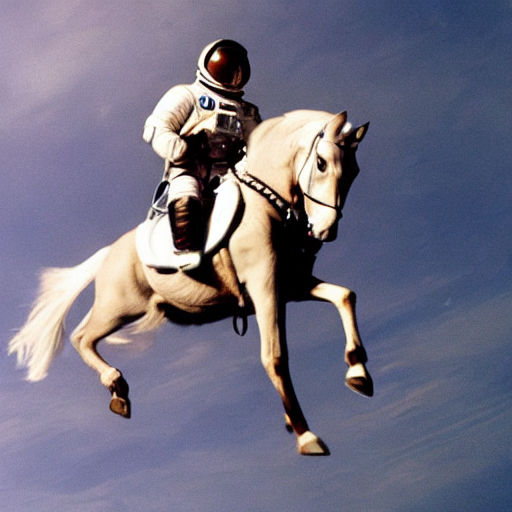

In [7]:
prompt = "a photograph of an astronaut riding a horse"
image = pipe(prompt).images[0]
image

In [8]:
result = pipe(prompt)
print(result)

  0%|          | 0/50 [00:00<?, ?it/s]

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x7F00F5A70790>], nsfw_content_detected=[False])


- The above model would return different output for the same prompt. To get the same image output, we use a generator with a set manual seed

In [9]:
generator = torch.Generator(device="cuda").manual_seed(1)

  0%|          | 0/50 [00:00<?, ?it/s]

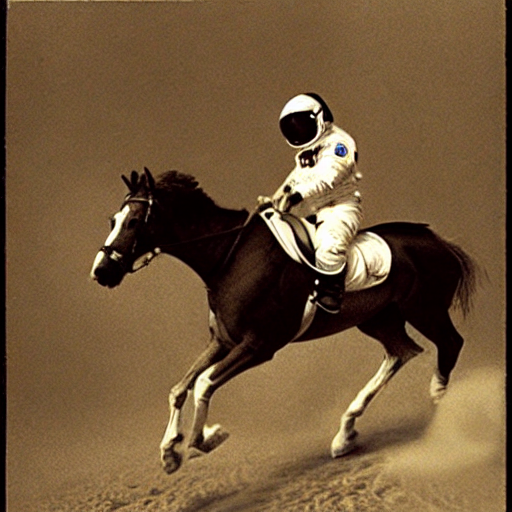

In [10]:
image = pipe(
    prompt, 
    generator=generator
).images[0]
image

- ``num_inference_steps`` can be changed

  0%|          | 0/15 [00:00<?, ?it/s]

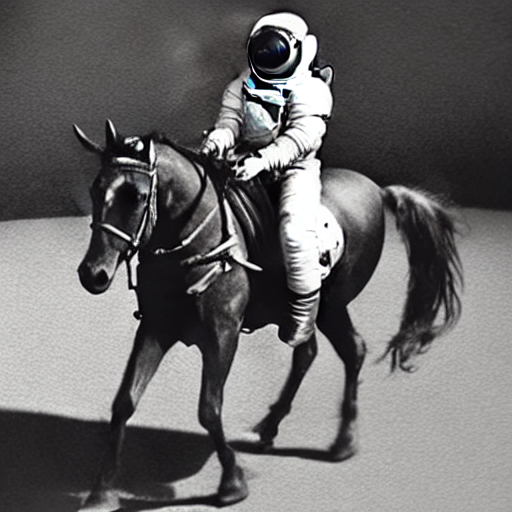

In [11]:
image = pipe(
    prompt, 
    num_inference_steps=15, 
    generator=generator
).images[0]
image

- guidance scale:
It is a way to increase the adherence to the conditional signal which in this case is text as well as overall sample quality. 

  0%|          | 0/50 [00:00<?, ?it/s]

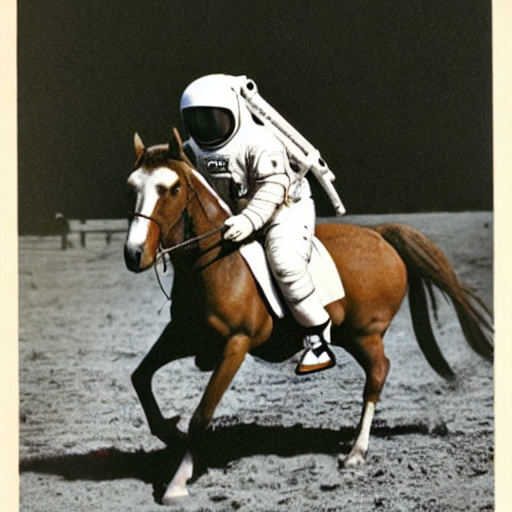

In [12]:
image = pipe(
    prompt, 
    guidance_scale=7.5, 
    generator=generator
).images[0]
image

- creating grid of images

In [13]:
from PIL import Image


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

  0%|          | 0/50 [00:00<?, ?it/s]

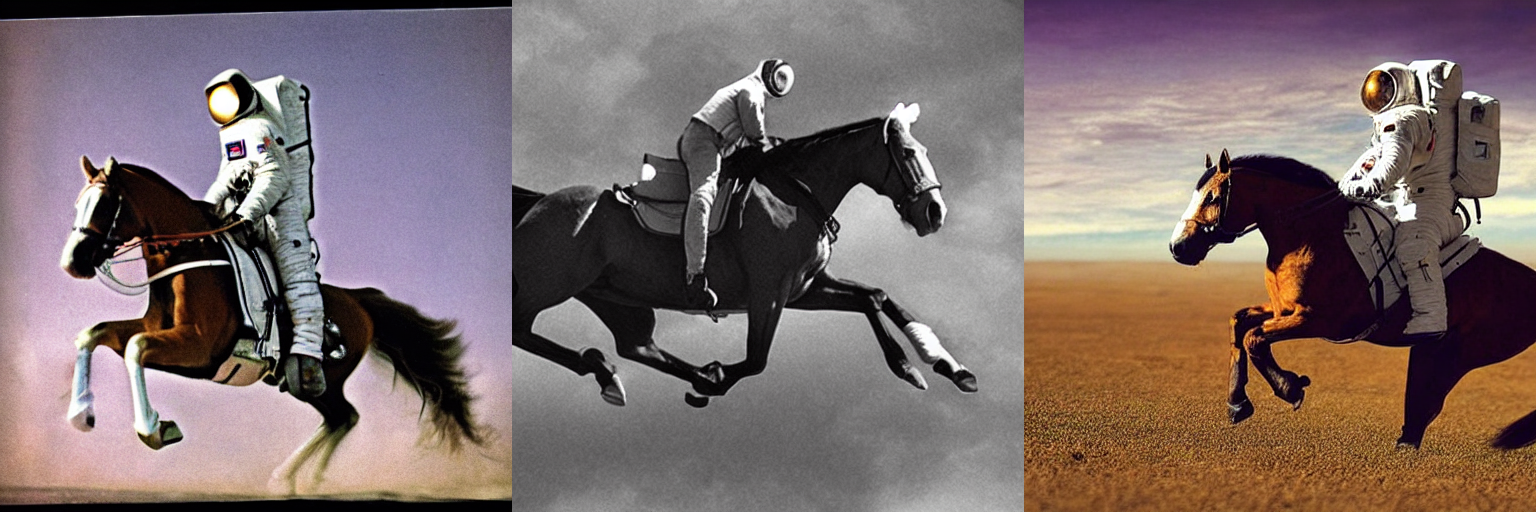

In [14]:
num_images = 3
prompt = ["a photograph of an astronaut riding a horse"] * num_images

images = pipe(prompt).images

grid = image_grid(images, rows=1, cols=3)
grid